# (To polish and clean up)


This notebook performs a regression to find a parameter in the function that returns the probability of COVID-19 transmission given distance over a two-dimensional space. 

1D droplet deposition model: Sun and Zhai 2020 https://doi.org/10.1016/j.scs.2020.102390

Exponential dose response model: Buonanno et al. 2020 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7474922/ 

Train data: Hu et al. 2021 https://doi.org/10.1093/cid/ciaa1057

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


: 

In [ ]:
# data from high-speed train

unit_distance = 0.5
mean_cotravel_time = 2.1

attack_rates_counts = np.array([[1, 2605, 1996, 1845, 1825, 1028],
                             [4791, 5084, 3664, 3464, 3525, 1872],
                             [4386, 4751, 3429, 3212, 3250, 1769],
                             [4026, 4395, 3110, 2945, 2970, 1589]])
counts = attack_rates_counts.flatten()[1:]

positive_counts = np.array([[0, 92, 33, 7, 7, 3],
                            [10, 12, 5, 3, 1, 1],
                            [11, 8, 8, 5, 3, 3],
                            [2, 2, 4, 3, 3, 1]])
num_pos_vec = positive_counts.flatten()[1:]

attack_rates = np.array([[100, 3.53, 1.65, 0.38, 0.38, 0.29],
                         [0.21, 0.24, 0.14, 0.09, 0.03, 0.05],
                         [0.25, 0.17, 0.23, 0.16, 0.09, 0.17],
                         [0.05, 0.05, 0.13, 0.10, 0.10, 0.06]]) * 0.01

row_distance = 0.9 * np.arange(4)
col_distance = np.array([0, 0.5, 1.05, 1.6, 2.1, 2.6])

distance_matrix = np.array([[np.sqrt(row_distance[i]**2 + col_distance[j]**2) for j in range(6)] for i in range(4)])
distance_vec = distance_matrix.flatten()[1:]

compute_beta = lambda d: (-0.1819*np.log(d)+0.43276)/d if d > 0.044 else 1

gamma_mask = 0.8

In [ ]:
print(distance_matrix)

[[0.         0.5        1.05       1.6        2.1        2.6       ]
 [0.9        1.02956301 1.38293167 1.83575598 2.28473193 2.7513633 ]
 [1.8        1.86815417 2.0838666  2.40831892 2.76586334 3.16227766]
 [2.7        2.74590604 2.89698119 3.13847097 3.42052628 3.74833296]]


In [ ]:
np.sum(attack_rates_counts)

71532

In [ ]:
datapoints_within_2m = 0
for i in range(4):
  for j in range(6):
    if distance_matrix[i,j] <= 2:
      datapoints_within_2m += attack_rates_counts[i,j]

print(datapoints_within_2m)

32587


In [ ]:
# Computes the angle that the susceptible is located wrt the source (horizontal neighbor = zero)
angle_matrix = np.array([[np.arctan(row_distance[i]/col_distance[j])*180/np.pi for j in range(6)] for i in range(4)])
angle_matrix[0,0]=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [ ]:
# compute the fraction of people counted at (|row|, |col|) that are seated within the cone of exposure

def fraction_in_cone(threshold_angle, scale_factor = 0.5, angle_matrix = angle_matrix):
  frac = np.zeros((4,6))
  for i in range(4):
    for j in range(6):
      if angle_matrix[i,j] < threshold_angle:
        frac[i,j]=1
      else:
        frac[i,j]=scale_factor
    
  return frac

In [ ]:
# As an example, we compute the fraction_in_cone_matrix for a threshold angle
# the output matrix represents ... (TODO: explain; make consistent with doc)
critical_angle = 60

frac_in_cone_matrix = fraction_in_cone(60)
print(frac_in_cone_matrix)

[[1.  1.  1.  1.  1.  1. ]
 [0.5 0.5 1.  1.  1.  1. ]
 [0.5 0.5 1.  1.  1.  1. ]
 [0.5 0.5 0.5 1.  1.  1. ]]


In [ ]:
# rescale the number of data points and attack rates 
attack_rates_counts_rescaled = attack_rates_counts * frac_in_cone_matrix
attack_rates_rescaled = attack_rates / frac_in_cone_matrix

# TODO: clean up and delete all the rescaling stuff, if we decide not to keep it

In [ ]:
# define function to compute the fraction of droplets received at distance d and parameter lambdaa

def compute_beta(d, lambdaa=1):
  if d > 0.044:
    return (-0.1819*np.log(d)+0.43276)/(d**lambdaa)
  else:
    return 1

In [ ]:
#compute_beta = lambda d: (-0.1819*np.log(d)+0.43276)/d if d > 0.044 else 1
beta_matrix = np.array([[compute_beta(distance_matrix[i,j]) for j in range(6)] for i in range(4)])

In [ ]:
x=-(beta_matrix*mean_cotravel_time).flatten()[1:] # scale with mean travel time 2.1 hrs

y = attack_rates.flatten()[1:]
y_rescaled = attack_rates_rescaled.flatten()[1:]



In [ ]:
counts = attack_rates_counts.flatten()[1:]
sigma = np.array([np.sqrt(y[i]*(1-y[i])/counts[i]) for i in range(len(y))])

counts_rescaled = attack_rates_counts_rescaled.flatten()[1:]
sigma_rescaled = np.array([np.sqrt(y_rescaled[i]*(1-y_rescaled[i])/counts_rescaled[i]) for i in range(len(y_rescaled))])

In [ ]:
# transforms attack rate to the exponent (linear reg objective)
process_y = lambda p: np.log(1 - p) if p < 1 else None
z = np.array([process_y(y[i]) for i in range(len(y))])
z_rescaled = np.array([process_y(y_rescaled[i]) for i in range(len(y_rescaled))])

#Third approach: Maximum Likelihood Estimation

Likelihood function:
$L(Y\mid \nu) = \prod_{(x,y)} \binom{N(x,y)}{Y(x,y)}\cdot\left(q(x,y)p(d(x,y),\nu)\right)^{Y(x,y)}\cdot \left(1-q(x,y)p(d(x,y),\nu)\right)^{N(x,y)-Y(x,y)}$


log likelihood function
$\log L(Y\mid \nu) = \sum_{(x,y)} \log\binom{N(x,y)}{Y(x,y)}+\left[ Y(x,y)\log\left(q(x,y)p(d(x,y),\nu)\right) + (N(x,y)-Y(x,y))\log\left(1-q(x,y)p(d(x,y),\nu)\right)\right]$


where 
$p(d(x,y),\nu) = 1-\exp\left(-\nu\cdot \frac{-0.1819\cdot \ln d(x,y) + 0.43276}{d(x,y)}\cdot T\right)$ and $T$ is the mean co-travel time

Maximum likelihood estimator:
$\nu^* = \arg\max_\nu \log L(Y\mid \nu)$


In [ ]:
from scipy.optimize import minimize
from scipy.special import binom


In [ ]:
def compute_log_likelihood(angle, constant, lambdaa, N=counts, Y=num_pos_vec, d=distance_vec, gamma_mask = gamma_mask):
  # compute frac q for given angle
  fraction_in_cone_matrix = fraction_in_cone(angle)
  q = fraction_in_cone_matrix.flatten()[1:]
  
  # compute log likelihood for given q and constant
  log_llh = 0
  for i in range(len(counts)):
    prob_trans = q[i] * (1-np.exp(-constant * mean_cotravel_time * gamma_mask * compute_beta(d[i],lambdaa)))
    log_llh += np.log(binom(N[i], Y[i])) + (Y[i] * np.log(prob_trans) + (N[i]-Y[i])*np.log(1-prob_trans))
  
  return log_llh

In [ ]:
lambdaa_grid = np.linspace(1,2,101)
angle_grid = np.linspace(0, 90, 19)
const_grid = np.linspace(0, 0.03, 61)

log_llh_over_lambdaa = []

In [ ]:
for l_idx in range(len(lambdaa_grid)):
  log_llh_array = np.zeros((len(angle_grid), len(const_grid)))

  for angle_idx in range(len(angle_grid)):
    for const_idx in range(len(const_grid)):
      log_llh_array[angle_idx, const_idx] = compute_log_likelihood(angle_grid[angle_idx], const_grid[const_idx], lambdaa_grid[l_idx])


  angle_MLEs, const_MLEs = np.where(log_llh_array == np.amax(log_llh_array))
  fitted_angle = angle_grid[angle_MLEs[-1]]
  fitted_const = const_grid[const_MLEs[-1]]

  log_llh_over_lambdaa.append(np.amax(log_llh_array))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
best_l_index = np.where(log_llh_over_lambdaa == np.amax(log_llh_over_lambdaa))
print(lambdaa_grid[best_l_index], np.amax(log_llh_over_lambdaa))

[1.26] -67.73817708914913


Text(0.5, 1.0, 'Maximum likelihood over lambda in [1,2]\n optimal point at (1.26, -67.74)')

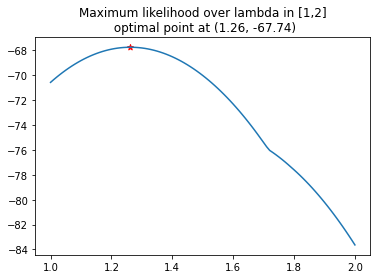

In [ ]:
plt.plot(lambdaa_grid, log_llh_over_lambdaa)
plt.scatter([1.26],[np.amax(log_llh_over_lambdaa)], marker = '*', color='r')
plt.title('Maximum likelihood over lambda in [1,2]\n optimal point at (1.26, -67.74)')

In [ ]:
fitted_const = const_grid[27]
fitted_const

0.0135

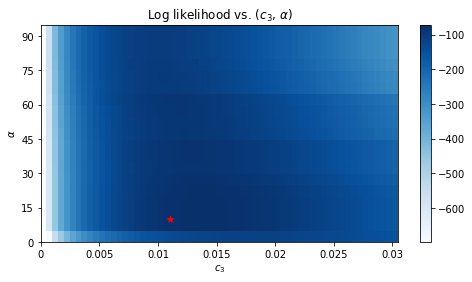

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
logllh=ax.pcolor(log_llh_array, cmap=plt.cm.Blues)
fig.colorbar(logllh, ax=ax)

ax.scatter([22],[2], marker = '*', color='r')

positions_x = (0, 10, 20, 30, 40, 50, 60)
labels_x = ("0", "0.005", "0.01", '0.015', '0.02', '0.025', '0.03')
plt.xticks(positions_x, labels_x)

positions_y = (0, 3, 6, 9, 12, 15, 18)
labels_y = ('0', '15', '30', '45', '60', '75', '90')
plt.yticks(positions_y, labels_y)

#plt.yticks(positions, labels)

plt.xlabel(r'$c_3$')
plt.ylabel(r'$\alpha$')
plt.title(r'Log likelihood vs. ($c_3$, $\alpha$)')
plt.show()

In [ ]:
# under the 'optimal' angle-constant value, plot data points (doubled or not), then plot separate (rescaled or not) fitted curves
# representing the conditional probability that a person at distance x is infected given in cone

In [ ]:
fraction_in_cone(angle_grid[1])

array([[1. , 1. , 1. , 1. , 1. , 1. ],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [ ]:
q_MLE = fraction_in_cone(angle_grid[1]).flatten()[1:]

In [ ]:
attack_rates_vec = attack_rates.flatten()[1:]
attack_rates_vec_rescaled = (attack_rates / fraction_in_cone(angle_grid[1])).flatten()[1:]

sigma = np.array([np.sqrt(attack_rates_vec[i]*(1-attack_rates_vec[i])/counts[i]) for i in range(len(attack_rates_vec))])
sigma_cond = np.array([np.sqrt(attack_rates_vec[i]*(1-attack_rates_vec[i])/counts[i])/q_MLE[i] for i in range(len(attack_rates_vec))])

#Plots

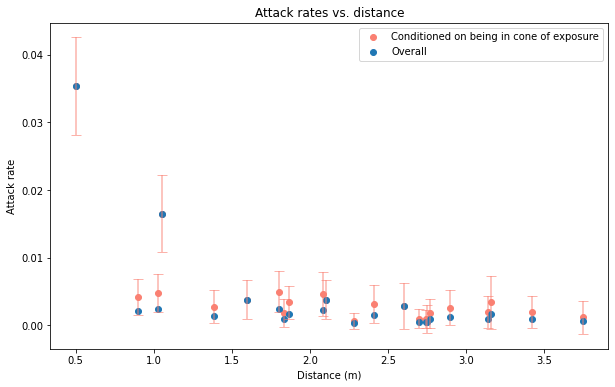

In [ ]:
# What do the rescaled data points look like themselves?
fig,ax = plt.subplots(figsize = (10,6))

#ax.errorbar(distance_vec, attack_rates_vec, yerr = 2*sigma, fmt = 'none', alpha=0.7)
ax.errorbar(distance_vec, attack_rates_vec_rescaled, yerr = 2*sigma_cond, color = 'salmon', fmt = 'none', capsize=5, alpha=0.6)
ax.scatter(distance_vec, attack_rates_vec_rescaled, color = 'salmon', label='Conditioned on being in cone of exposure')
ax.scatter(distance_vec, attack_rates_vec, label = 'Overall')


ax.set_title('Attack rates vs. distance')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Attack rate')
ax.legend()

Text(0, 0.5, 'Attack rate')

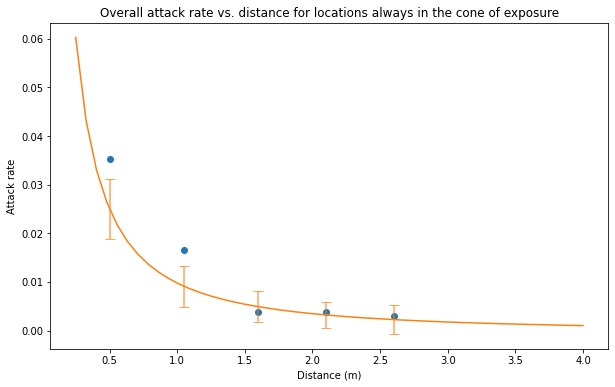

In [ ]:
fig,ax = plt.subplots(figsize = (10,6))
dd = np.linspace(0.25, 4, 50)

ax.scatter(distance_vec[:5], attack_rates_vec[:5], label = 'Always in cone')
pred_at_datapoints_1 = np.asarray([1-np.exp(-1 * fitted_const * gamma_mask * 2.1 * (-0.1819*np.log(d)+0.43276)/d) for d in distance_vec[:5]])
#ax.errorbar(distance_vec[:5], attack_rates_vec[:5], yerr = 2*sigma[:5], fmt = 'none', alpha=0.7)
ax.errorbar(distance_vec[:5], pred_at_datapoints_1, 
            yerr=2*np.sqrt(pred_at_datapoints_1*(1-pred_at_datapoints_1)/counts[:5]), capsize=5,
            fmt='none', alpha=0.7, color='#ff7f0e')
ax.plot(dd, [1-np.exp(-1 * fitted_const * gamma_mask * 2.1 * (-0.1819*np.log(d)+0.43276)/d) for d in dd], color='#ff7f0e')

ax.set_title('Overall attack rate vs. distance for locations always in the cone of exposure')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Attack rate')


Text(0, 0.5, 'Attack rate')

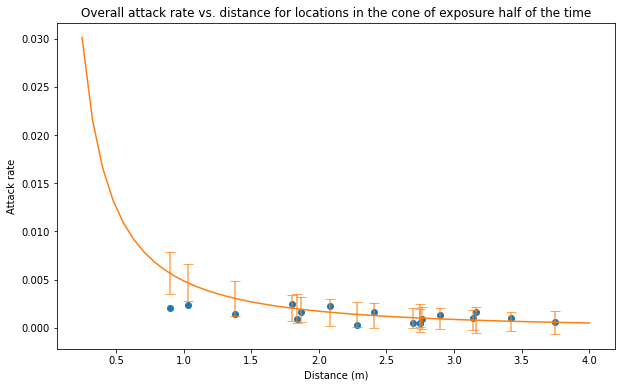

In [ ]:
fig,ax = plt.subplots(figsize = (10,6))

ax.scatter(distance_vec[5:], attack_rates_vec[5:], label = 'Half in cone')
#ax.errorbar(distance_vec[5:], attack_rates_vec[5:], yerr = 2*sigma[5:], fmt = 'none', alpha=0.7)
#ax.plot(dd, [0.5 * (1-np.exp(-1 * fitted_const * 2.1 * compute_beta(d))) for d in dd])
pred_at_datapoints_2 = np.asarray([0.5*(1-np.exp(-1 * fitted_const * gamma_mask * 2.1 * (-0.1819*np.log(d)+0.43276)/d)) for d in distance_vec[5:]])
ax.errorbar(distance_vec[5:], pred_at_datapoints_2, 
            yerr=2*np.sqrt(pred_at_datapoints_2*(1-pred_at_datapoints_2)/counts[5:]), 
            marker='.', capsize=5,
            fmt='none', alpha=0.7, color='#ff7f0e')
ax.plot(dd, [0.5 * (1-np.exp(-1 * fitted_const * gamma_mask * 2.1 * (-0.1819*np.log(d)+0.43276)/d)) for d in dd], color='#ff7f0e')

ax.set_title('Overall attack rate vs. distance for locations in the cone of exposure half of the time')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Attack rate')

In [ ]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


OLS on log(1-p), no outliers removed 0.01155830729025866 

OLS on log(1-p), two outliers removed 0.003788714394567805 

OLS, direct optimization 0.011458453958200252 

WLS, direct optimization 0.0036783073173596577 



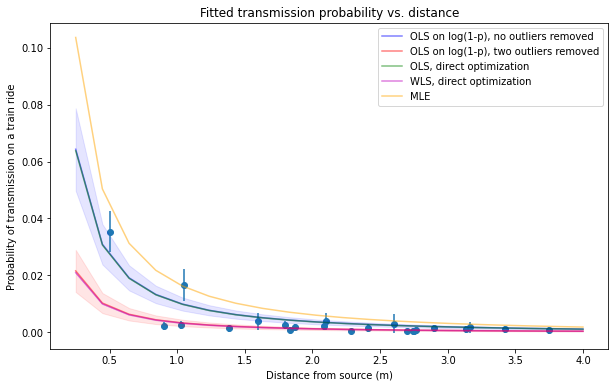

In [ ]:
# Regression results for the full-disk case (original attack rates and data counts)

fig, ax = plt.subplots(figsize = (10,6))
constants = [const0, const1, c_fit_nosigma[0], c_fit_sigma[0], MLE_estimate]

conf_intervals = [const0_conf_int, const1_conf_int, 
                  [c_fit_nosigma[0] - 1.96 * c_fit_nosigma_var[0,0], c_fit_nosigma[0]+ 1.96 * c_fit_nosigma_var[0,0]],
                  [c_fit_sigma[0] - 1.96 * c_fit_nosigma_var[0,0], c_fit_sigma[0]+ 1.96 * c_fit_sigma_var[0,0]]]

ax.scatter(distance_matrix.reshape(-1, 1)[1:], y)
ax.errorbar(distance_matrix.reshape(-1, 1)[1:], y, yerr = 2*sigma, fmt = 'none')

for i in range(4):
  ax.fill_between(dd, [1-np.exp(-1 * conf_intervals[i][0] * 2.1 * compute_beta(d)) for d in dd],\
                  [1-np.exp(-1 * conf_intervals[i][1] * 2.1 * compute_beta(d)) for d in dd],
                  color = colors[i], alpha=0.1)
  ax.plot(dd, [1-np.exp(-1 * constants[i] * 2.1 * compute_beta(d)) for d in dd], label = labels[i], alpha=0.5, color=colors[i])

ax.plot(dd, [1-np.exp(-1 * MLE_estimate * 2.1 * compute_beta(d)) for d in dd], label = 'MLE', alpha=0.5, color='orange')

ax.set_xlabel('Distance from source (m)')
ax.set_ylabel('Probability of transmission on a train ride')
ax.legend()
ax.set_title('Fitted transmission probability vs. distance')

for i in range(4):
  print(labels[i], constants[i], '\n')


OLS on log(1-p), no outliers removed 0.012212796924417983 

OLS on log(1-p), two outliers removed 0.005639435805008035 

OLS, direct optimization 0.012128475829536781 

WLS, direct optimization 0.005225658196152868 



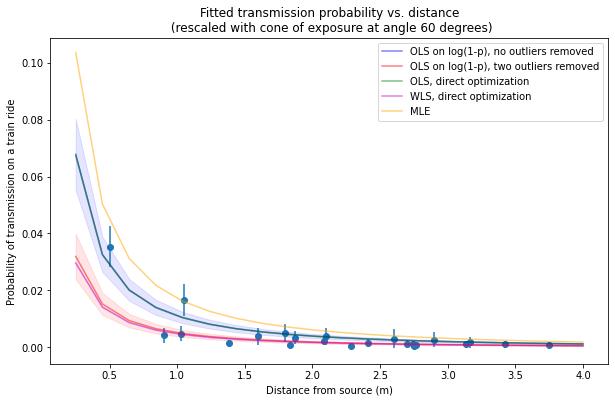

In [ ]:
# Regression results for the angle_threshold_rescaled case 
fig, ax = plt.subplots(figsize = (10,6))

colors = ['b', 'r', 'g', 'm']

constants = [const0_2, const1_2, c_fit_nosigma_2[0], c_fit_sigma_2[0]]

labels = ['OLS on log(1-p), no outliers removed',
          'OLS on log(1-p), two outliers removed',
          'OLS, direct optimization',
          'WLS, direct optimization']

conf_intervals = [const0_2_conf_int, const1_2_conf_int, 
                  [c_fit_nosigma_2[0] - 1.96 * c_fit_nosigma_var_2[0,0], c_fit_nosigma_2[0]+ 1.96 * c_fit_nosigma_var_2[0,0]],
                  [c_fit_sigma_2[0] - 1.96 * c_fit_nosigma_var_2[0,0], c_fit_sigma_2[0]+ 1.96 * c_fit_sigma_var_2[0,0]]]

ax.scatter(distance_matrix.reshape(-1, 1)[1:], y_rescaled)
ax.errorbar(distance_matrix.reshape(-1, 1)[1:], y_rescaled, yerr = 2*sigma_rescaled, fmt = 'none')

dd = np.linspace(0.25, 4, 20)

for i in range(4):
  ax.fill_between(dd, [1-np.exp(-1 * conf_intervals[i][0] * 2.1 * compute_beta(d)) for d in dd],\
                  [1-np.exp(-1 * conf_intervals[i][1] * 2.1 * compute_beta(d)) for d in dd],
                  color = colors[i], alpha=0.1)
  ax.plot(dd, [1-np.exp(-1 * constants[i] * 2.1 * compute_beta(d)) for d in dd], label = labels[i], alpha=0.5, color=colors[i])

ax.plot(dd, [(1-np.exp(-1 * MLE_estimate * 2.1 * compute_beta(d))) for d in dd], label = 'MLE', alpha=0.5, color='orange')


ax.set_xlabel('Distance from source (m)')
ax.set_ylabel('Probability of transmission on a train ride')
ax.legend()
ax.set_title('Fitted transmission probability vs. distance\n (rescaled with cone of exposure at angle {} degrees)'.format(critical_angle))


for i in range(4):
  print(labels[i], constants[i], '\n')

In [ ]:
a

1

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Fitted transmission probability vs. distance')

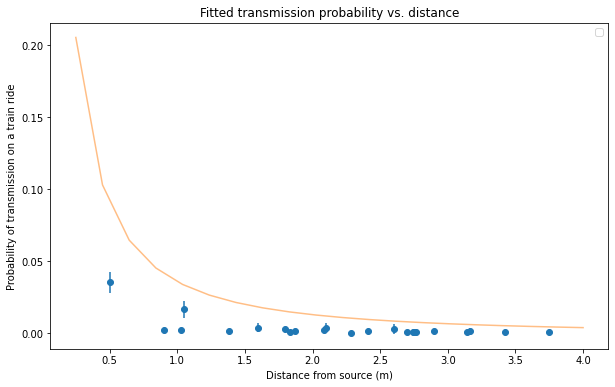

In [ ]:
# Regression results for the full-disk case (original attack rates and data counts)

fig, ax = plt.subplots(figsize = (10,6))
constants = 0.04

#conf_intervals = [const0_conf_int, const1_conf_int, 
#                  [c_fit_nosigma[0] - 1.96 * c_fit_nosigma_var[0,0], c_fit_nosigma[0]+ 1.96 * c_fit_nosigma_var[0,0]],
#                  [c_fit_sigma[0] - 1.96 * c_fit_nosigma_var[0,0], c_fit_sigma[0]+ 1.96 * c_fit_sigma_var[0,0]]]

ax.scatter(distance_matrix.reshape(-1, 1)[1:], y)
ax.errorbar(distance_matrix.reshape(-1, 1)[1:], y, yerr = 2*sigma, fmt = 'none')

  #ax.fill_between(dd, [1-np.exp(-1 * conf_intervals[i][0] * 2.1 * compute_beta(d)) for d in dd],\
  #                [1-np.exp(-1 * conf_intervals[i][1] * 2.1 * compute_beta(d)) for d in dd],
  #                color = colors[i], alpha=0.1)
ax.plot(dd, [1-np.exp(-1 * constants * 2.1 * compute_beta(d)) for d in dd], alpha=0.5)

#ax.plot(dd, [1-np.exp(-1 * MLE_estimate * 2.1 * compute_beta(d)) for d in dd], label = 'MLE', alpha=0.5, color='orange')

ax.set_xlabel('Distance from source (m)')
ax.set_ylabel('Probability of transmission on a train ride')
ax.legend()
ax.set_title('Fitted transmission probability vs. distance')

